### Numerical experiments of microscale perfusion and gas exchange

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyvista
import ufl
import time
from matplotlib import font_manager
from pathlib import Path
from mpi4py import MPI
from petsc4py import PETSc
import dolfinx
print(dolfinx.__version__)
print(np.__version__)
from dolfinx import fem, mesh, plot, nls, log, io
import meshio
import os
import sys
import seaborn as sns

sys.path.append('../')

%load_ext autoreload
%autoreload 2

0.7.3
1.26.4


In [3]:
pyvista.set_jupyter_backend('client')
pyvista.set_plot_theme(pyvista.themes.ParaViewTheme())
# pyvista.global_theme.background = 'white'
# pyvista.global_theme.font.color = 'black'
pyvista.global_theme.font.family = 'arial'
pyvista.global_theme.cmap = 'viridis'

# pyvista.global_theme.line_width = 0.2
# pyvista.global_theme.lighting_params.diffuse = 1
# pyvista.global_theme.lighting_params.roughness = 1
# pyvista.global_theme.lighting_params.metallic = 1
# pyvista.global_theme.lighting_params.specular = 0

In [4]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

font_path = '../src/fonts/Helvetica.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [5]:
# Importing model and utility functions

from src.model import *
from src.utils import *

#### Single-capillary simulations

In [6]:
L = 200
a = 3

vertex = [L,2*a,2*a]
num_nodes = [100,6,6]
z_slab_domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], vertex], 
                         num_nodes, mesh.CellType.tetrahedron) 

In [7]:
def all(x):
    return np.full(x.shape[1], True, dtype=bool)

print(np.mean(z_slab_domain.h(z_slab_domain.topology.dim, mesh.locate_entities(z_slab_domain, z_slab_domain.topology.dim, all))))

2.4494897427831783


In [8]:
results_folder = r"../results-data/"
exp_folder = "slab_test_200um"

z_slab_model = PerfusionGasExchangeModel(mesh_path=None,
                                  results_path=results_folder,
                                  exp_path=exp_folder,
                                  params=None)

max_dims = vertex
min_dims = [0,0,0]

z_slab_model.Setup(z_slab_domain, max_dims = max_dims, min_dims = min_dims, atol=1E-10, imported=False)
z_slab_model.parameter_setup()

Porosity = 0
Total boundary face number = 4944
Inlet face number = 72
Outlet face number = 72
Air face number = 4800


In [9]:
# plot_mesh(z_slab_domain)

In [10]:
z_slab_model.p_params["uin"] = 800/3
p, u = z_slab_model.Perfusion(z_slab_domain, plot=False, save=False, verbose=False)



-------   Perfusion problem instanced.  -------
Pressure field found.


------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.333
O2 and CO2 partial pressures found in 7 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.667
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 1
O2 and CO2 partial pressures found in 5 iterations.
Starting postprocessing.
Finished postprocessing at t = 0.1051 s.
------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.333
O2 and CO2 partial pressures found in 7 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.667
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 1
O2 and CO2 partial pressures found in 5 iterations.
Starting postprocessing.
Finis

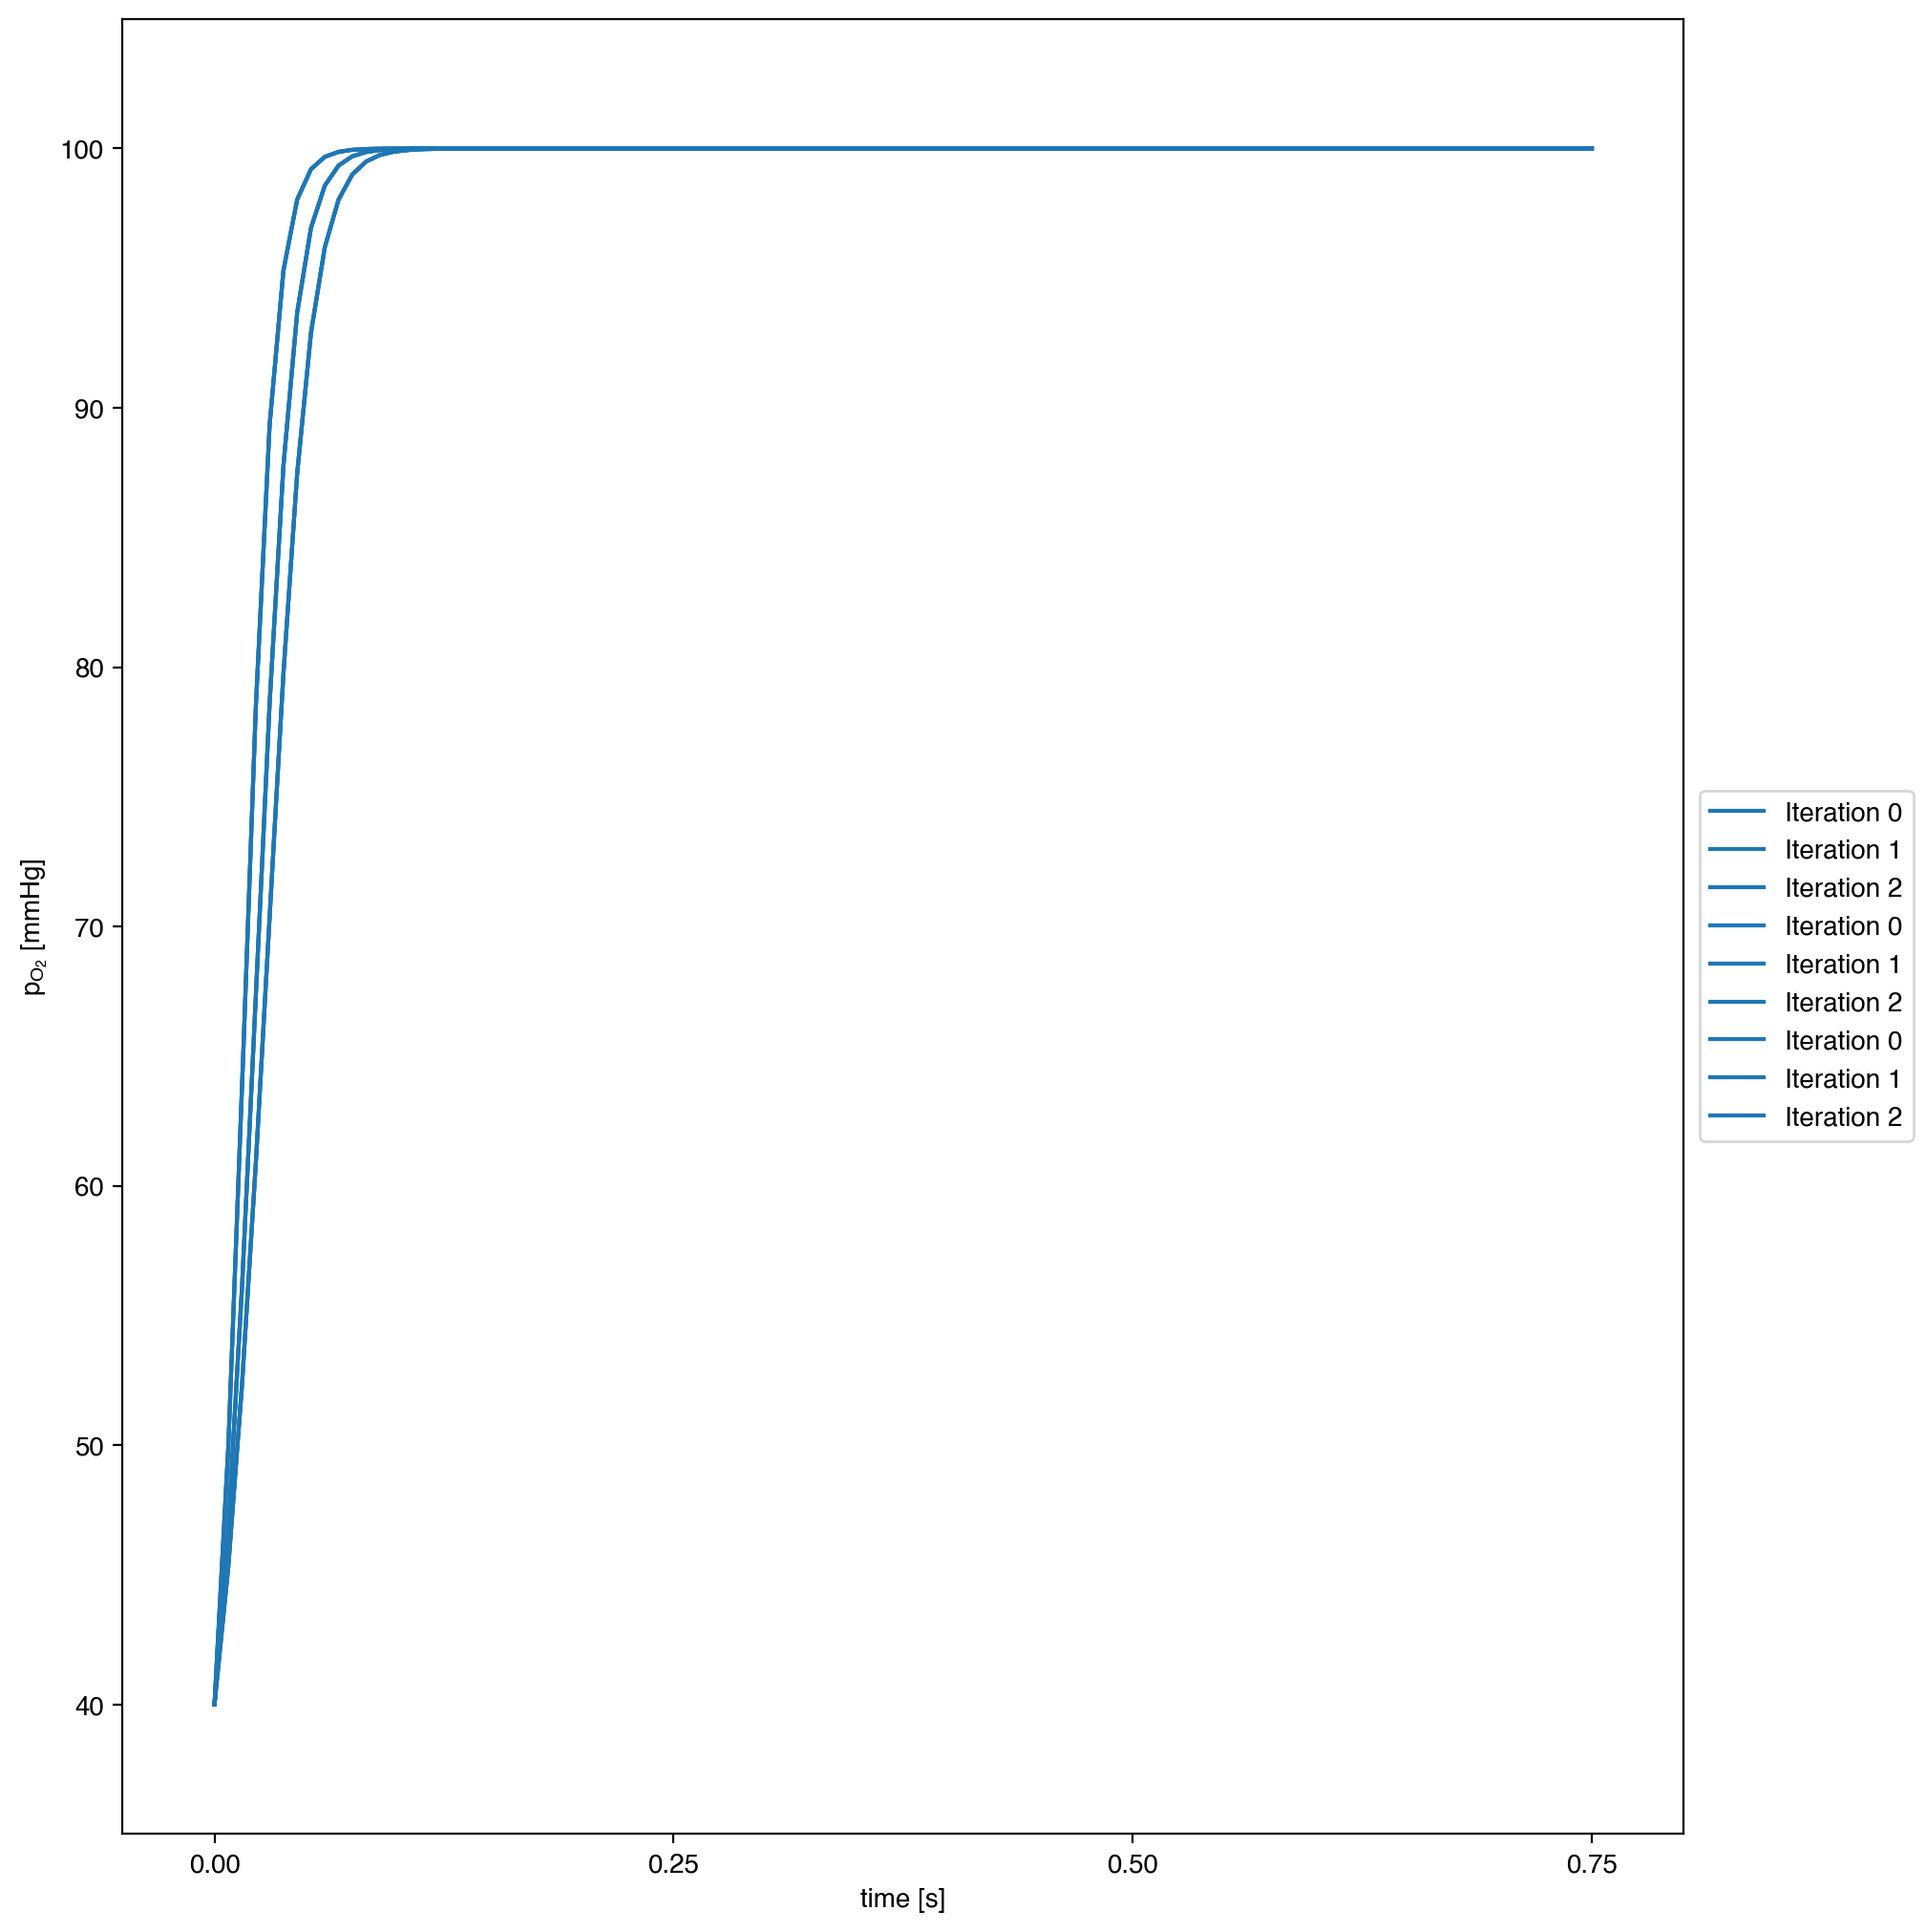

In [25]:
n1 = 3
n2 = 6
Ns = range(n1, n2)
colorp = sns.color_palette("tab10", n2-n1)


p_O2_all  = []
p_CO2_all = []


fig, ax = plt.subplots(figsize=(10,10), dpi=200, layout='constrained')


for N in Ns:
    p_O2_N  = []
    p_CO2_N = []

    p_val = 0
    guess = z_slab_model.GasExchange(z_slab_domain, guess=None, save=False, 
                            plot=False, p_val = p_val, 
                            postprocess=False, plot_lines=True, verbose=False)

    p_O2_N.append(z_slab_model.results_dict["p_O2"]["3.0"])
    p_CO2_N.append(z_slab_model.results_dict["p_O2"]["3.0"])

    N = 3
    for i in range(N):
        if i != N-1:
            p_val += 1/N
            guess = z_slab_model.GasExchange(z_slab_domain, guess=guess, save=False, 
                                    plot=False, p_val = p_val, 
                                    postprocess=False, plot_lines=True, verbose=False)
        else:
            p_val = 1
            p_XY = z_slab_model.GasExchange(z_slab_domain, guess=guess, save=True, 
                                    plot=False, p_val = p_val, 
                                    postprocess=True, plot_lines=True, verbose=False)
            
        p_O2_N.append(z_slab_model.results_dict["p_O2"]["3.0"])
        p_CO2_N.append(z_slab_model.results_dict["p_O2"]["3.0"])

    for i, p_O2 in enumerate(p_O2_N):

        ax.plot(z_slab_model.x/(800/3), p_O2,  color=colorp[N-n1], label=f'Iteration {i}')

ax.set_xlabel(r"time [s]", size=10)
ax.set_xticks([0,0.25,0.50,0.75])
ax.set_xlim(-0.05, 0.8)
ax.set_ylim(35, 105)
ax.set_yticks([40,50,60,70,80,90,100])
ax.set_ylabel(r"$\mathdefault{p_{O_2}}$ [mmHg]", size=10)
ax.tick_params(axis='both', labelsize=10)
fig.legend(loc='outside center right')
# plt.savefig("./figs/pO2comp.pdf", transparent=True)
plt.show()

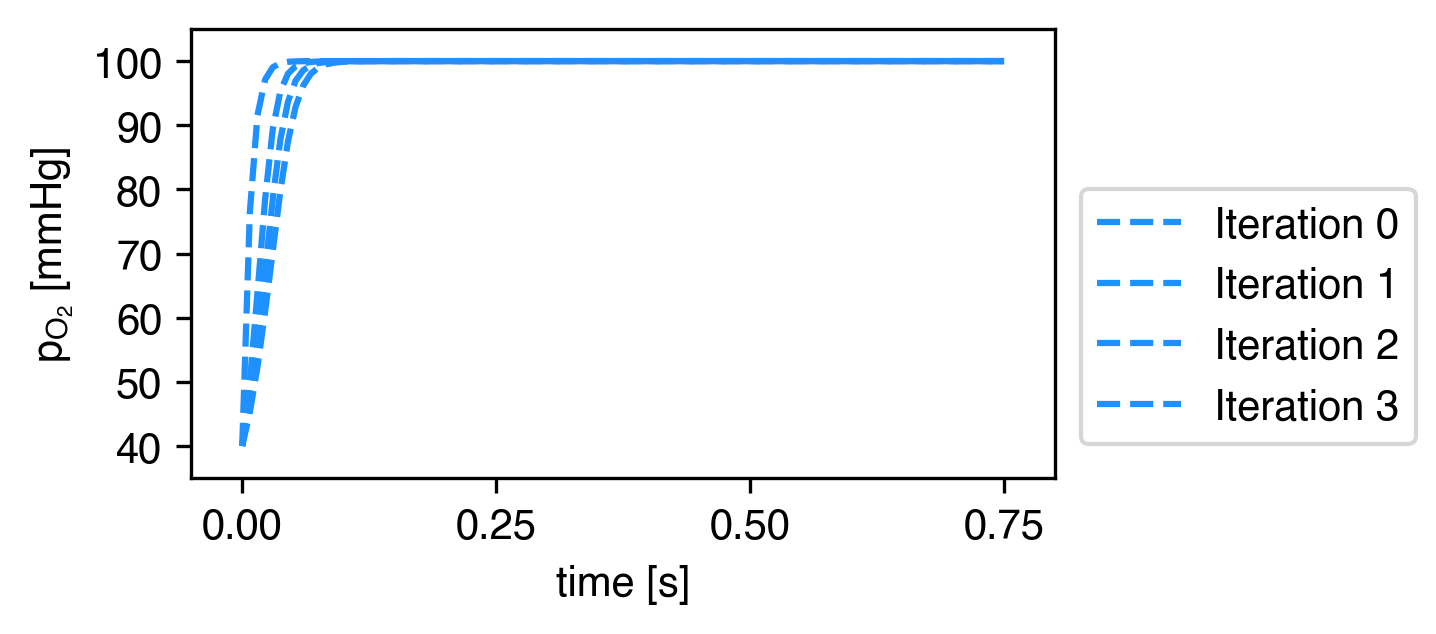

In [20]:
# PO2 comparison between iterations

fig, ax = plt.subplots(figsize=(4.7,2), dpi=300, layout='constrained')

for n in Ns:
    for i, p_O2 in enumerate(p_O2_all):

        ax.plot(z_slab_model.x/(800/3), p_O2, '--', color='dodgerblue', label=f'Iteration {i}')

ax.set_xlabel(r"time [s]", size=10)
ax.set_xticks([0,0.25,0.50,0.75])
ax.set_xlim(-0.05, 0.8)
ax.set_ylim(35, 105)
ax.set_yticks([40,50,60,70,80,90,100])
ax.set_ylabel(r"$\mathdefault{p_{O_2}}$ [mmHg]", size=10)
ax.tick_params(axis='both', labelsize=10)
fig.legend(loc='outside center right')
# plt.savefig("./figs/pO2comp.pdf", transparent=True)
plt.show()

In [ ]:
# Equilibrium time calculation.

d = z_slab_model.results_dict["p_O2"]['3.0']
for i in range(d.shape[0]):
    if np.abs(d[i] - 100) <= 0.5:
        print(f"O2 equilibrium reached at {round(z_slab_model.x[i], 3)} um, {round(z_slab_model.x[i], 2)/(800/3)*(1000)} ms.") 
        break

O2 equilibrium reached at 22.223 um, 83.325 ms.


In [ ]:
plot_scalar_field(fem.FunctionSpace(z_slab_domain, ("CG", 2)), p)

In [ ]:
slab_p_O2, slab_p_CO2 = p_XY.split()
slab_V_mesh = fem.functionspace(z_slab_domain, ('Lagrange', 1))

In [ ]:
slab_p_O2_int = fem.Function(slab_V_mesh, name="p_O2")
slab_p_O2_int.interpolate(fem.Expression(slab_p_O2, slab_V_mesh.element.interpolation_points()))

plot_scalar_field(slab_V_mesh, slab_p_O2_int)

In [ ]:
slab_p_CO2_int = fem.Function(slab_V_mesh, name="p_CO2")
slab_p_CO2_int.interpolate(fem.Expression(slab_p_CO2, slab_V_mesh.element.interpolation_points()))

plot_scalar_field(slab_V_mesh, slab_p_CO2_int)

In [ ]:
# Slice-averaged values along flow direction, Zurita & Hurtado (2023)

p_O2_zurita = []
z_O2_zurita = []
with open("./csv-results/p_O2_zurita.csv", "r") as file:
    i = 0
    for row in file:
        if i != 0:
            p_O2_zurita.append(row.split(",")[0])
            z_O2_zurita.append(row.split(",")[1])
        i += 1

p_O2_zurita = np.asarray(p_O2_zurita, float)
z_O2_zurita = np.asarray(z_O2_zurita, float)/(800/3)

p_CO2_zurita = []
z_CO2_zurita = []
with open("./csv-results/p_CO2_zurita.csv", "r") as file:
    i = 0
    for row in file:
        if i != 0:
            p_CO2_zurita.append(row.split(",")[0])
            z_CO2_zurita.append(row.split(",")[1])
        i += 1

p_CO2_zurita = np.asarray(p_CO2_zurita, float)
z_CO2_zurita = np.asarray(z_CO2_zurita, float)/(800/3)

In [ ]:
# Importing Brighenti et al. values recovered from plot digitizer.

p_O2_brighenti = []
x_O2_brighenti = []
with open("./csv-results/brighenti_po2.csv", "r") as file:
    for row in file:
            p_O2_brighenti.append(float(row.split(";")[1].strip("\n").strip().replace(',', '.')))
            x_O2_brighenti.append(float(row.split(";")[0].strip("\n").strip().replace(',', '.')))

In [ ]:
# PO2 comparison between models.

fig, ax = plt.subplots(figsize=(4.7,2), dpi=300, layout='constrained')

ax.scatter(x_O2_brighenti[:-2], p_O2_brighenti[:-2], s=2, color='green', label='Brighenti et al. [31]')
ax.plot(z_O2_zurita, p_O2_zurita, color='orangered', label='Zurita & Hurtado [16]')
ax.plot(z_slab_model.x/(800/3), z_slab_model.results_dict["p_O2"]['3.0'], '--', color='dodgerblue', label=r'Our model')

ax.set_xlabel(r"time [s]", size=10)
ax.set_xticks([0,0.25,0.50,0.75])
ax.set_xlim(-0.05, 0.8)
ax.set_ylim(35, 105)
ax.set_yticks([40,50,60,70,80,90,100])
ax.set_ylabel(r"$\mathdefault{p_{O_2}}$ [mmHg]", size=10)
ax.tick_params(axis='both', labelsize=10)
fig.legend(loc='outside center right')
# plt.savefig("./figs/pO2comp.pdf", transparent=True)
plt.show()

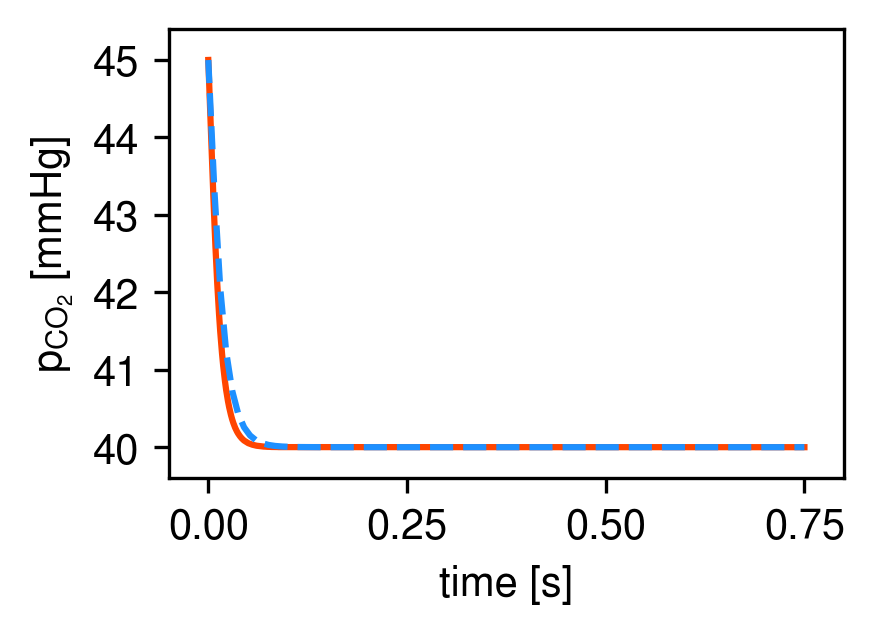

In [ ]:
# PCO2 comparison between models.

fig, ax = plt.subplots(figsize=(2.8,2), dpi=300, layout='constrained')
ax.plot(z_CO2_zurita, p_CO2_zurita, color='orangered', label='[15]')
ax.plot(z_slab_model.x/(800/3), z_slab_model.results_dict["p_CO2"]['3.0'], '--', color='dodgerblue', label=r'Our model')

ax.set_xlabel(r"time [s]", size=10)
ax.set_ylim(39.6, 45.4)
ax.set_yticks([40,41,42,43,44,45])
ax.set_xticks([0,0.25,0.50,0.75])
ax.set_xlim(-0.05, 0.8)

ax.set_ylabel(r"$\mathdefault{p_{CO_2}}$ [mmHg]", size=10)
ax.tick_params(axis='both', labelsize=10)
# plt.savefig("./figs/pCO2comp.pdf", transparent=True)
plt.show()

#### Sensitivity analysis - $u_{in}$, pH

In [ ]:
L = 60
a = 4

vertex = [L,2*a,2*a]
num_nodes = [100,6,6]
slab_domain = mesh.create_box(MPI.COMM_WORLD, [[0.0, 0.0, 0.0], vertex], 
                         num_nodes, mesh.CellType.tetrahedron) 

results_folder = r"../results-data/"
exp_folder = "slab_test_60um"

slab_model = PerfusionGasExchangeModel(mesh_path=None,
                                  results_path=results_folder,
                                  exp_path=exp_folder,
                                  params=None)

max_dims = vertex
min_dims = [0,0,0]

slab_model.Setup(slab_domain, max_dims = max_dims, min_dims = min_dims, atol=1E-10, imported=False)
slab_model.parameter_setup()

max_dims = [60, 8, 8]
min_dims = [0, 0, 0]
Total number = 4944
Inlet number = 72
Outlet number = 72
Air number = 4800


In [ ]:
# Inlet blood velocity testing

us = [80, 150, 250, 500, 1000]
results_us = {}

for u_in in us:

    slab_model.p_params["uin"] = u_in
    p, u = slab_model.Perfusion(slab_domain, plot=False, save=True, verbose=False)

    p_val = 0
    guess = slab_model.GasExchange(slab_domain, guess=None, save=False, 
                              plot=False, p_val = p_val, 
                              postprocess=False, plot_lines=False, verbose=False)
    N = 4
    for i in range(N):
        if i != N-1:
            p_val += 1/N
            guess = slab_model.GasExchange(slab_domain, guess=guess, save=False, 
                                      plot=False, p_val = p_val, 
                                      postprocess=False, plot_lines=False, verbose=False)
        else:
            p_val = 1
            guess = slab_model.GasExchange(slab_domain, guess=guess, save=True, 
                                      plot=False, p_val = p_val, 
                                      postprocess=True, plot_lines=True, verbose=False)
            
    results_us[f"{u_in}"] = slab_model.results_dict

-------   Perfusion problem instanced.  -------
Pressure field found.
------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.25
O2 and CO2 partial pressures found in 7 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.5
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.75
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 1
O2 and CO2 partial pressures found in 5 iterations.
Starting postprocessing.
Finished postprocessing at t = 0.0786 s.
-------   Perfusion problem instanced.  -------
Pressure field found.
------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.25
O2 and CO2 partial pressures found in 7 iterations.
------

In [ ]:
# pH testing

u_in = 80
pHs_rbc = [7.0, 7.2, 7.4, 7.6, 7.8] 
pHs_pla = [(pH_rbc - 1.357)/0.795 for pH_rbc in pHs_rbc]
results_pHs = {}

for pH_rbc, pH_pla in zip(pHs_rbc, pHs_pla):
    slab_model.p_params["uin"] = u_in
    slab_model.dash_params["pH_rbc"] = pH_rbc
    slab_model.dash_params["pH_pla"] = pH_pla
    print(f"pH_rbc = {pH_rbc}, pH_pla = {pH_pla}")
    p, u = slab_model.Perfusion(slab_domain, plot=False, save=True, verbose=False)

    p_val = 0
    guess = slab_model.GasExchange(slab_domain, guess=None, save=False, 
                              plot=False, p_val = p_val, 
                              postprocess=False, plot_lines=False, verbose=False)
    N = 4
    for i in range(N):
        p_val += 1/N
        if i != N-1:
            guess = slab_model.GasExchange(slab_domain, guess=guess, save=False, 
                                      plot=False, p_val = p_val, 
                                      postprocess=False, plot_lines=False, verbose=False)
        else:
            guess = slab_model.GasExchange(slab_domain, guess=guess, save=False, 
                                      plot=False, p_val = p_val, 
                                      postprocess=True, plot_lines=True, verbose=False)
            
    results_pHs[f"{pH_rbc}"] = slab_model.results_dict

pH_rbc = 7.0, pH_pla = 7.098113207547169
-------   Perfusion problem instanced.  -------
Pressure field found.
------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.25
O2 and CO2 partial pressures found in 7 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.5
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 0.75
O2 and CO2 partial pressures found in 5 iterations.
------- Gas exchange problem instanced. ------- lambda = 1.0
O2 and CO2 partial pressures found in 4 iterations.
Starting postprocessing.
Finished postprocessing at t = 0.9993 s.
pH_rbc = 7.2, pH_pla = 7.3496855345911944
-------   Perfusion problem instanced.  -------
Pressure field found.
------- Gas exchange problem instanced. ------- lambda = 0
O2 and CO2 partial pressures found in 2 iterations.
------- Gas exchange problem instan

In [ ]:
func_units = ["", "", "[mM]", "[mM]", "[mM]", "[mmHg]", "[mmHg]"]
func_factor = [1, 1, 1E15, 1E15, 1E15, 1, 1]
func_names = [r"$\mathdefault{S_{HbO_2}}$", r"$\mathdefault{S_{HbCO_2}}$", r"$\mathdefault{c_{O_2}}$", r"$\mathdefault{c_{CO_2}}$", r"[HCO$\mathdefault{_3^-}$]", r"$\mathdefault{p_{O_2}}$", r"$\mathdefault{p_{CO_2}}$"]
func_tags = ["S_HbO2", "S_HbCO2", "c_O2", "c_CO2", "HCO3", "p_O2", "p_CO2"]

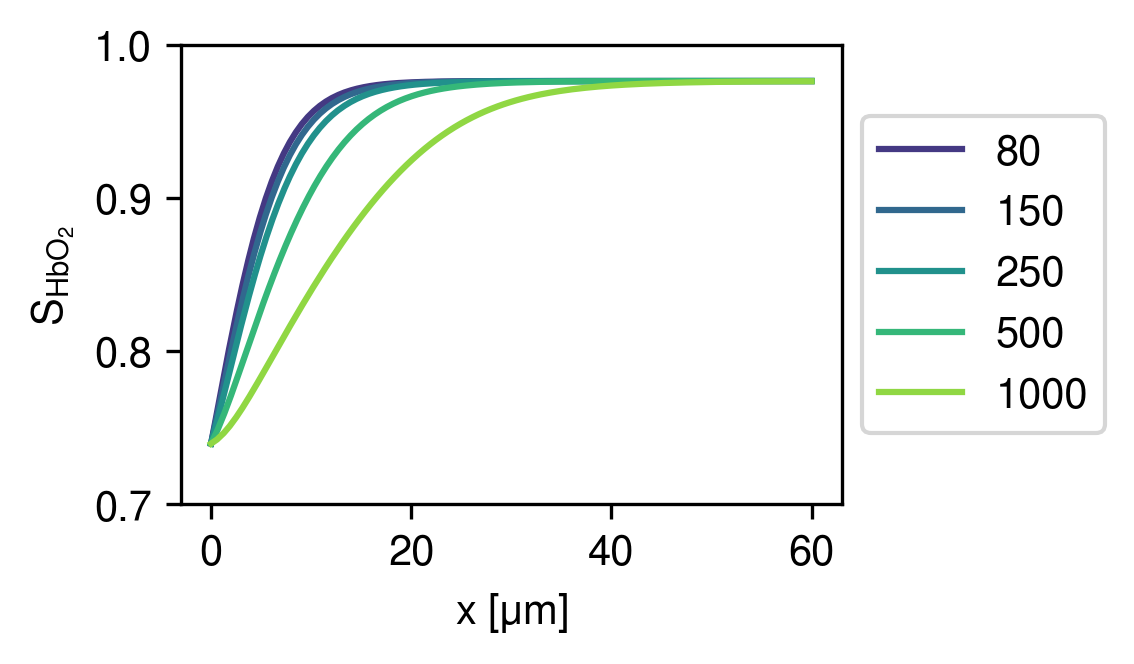

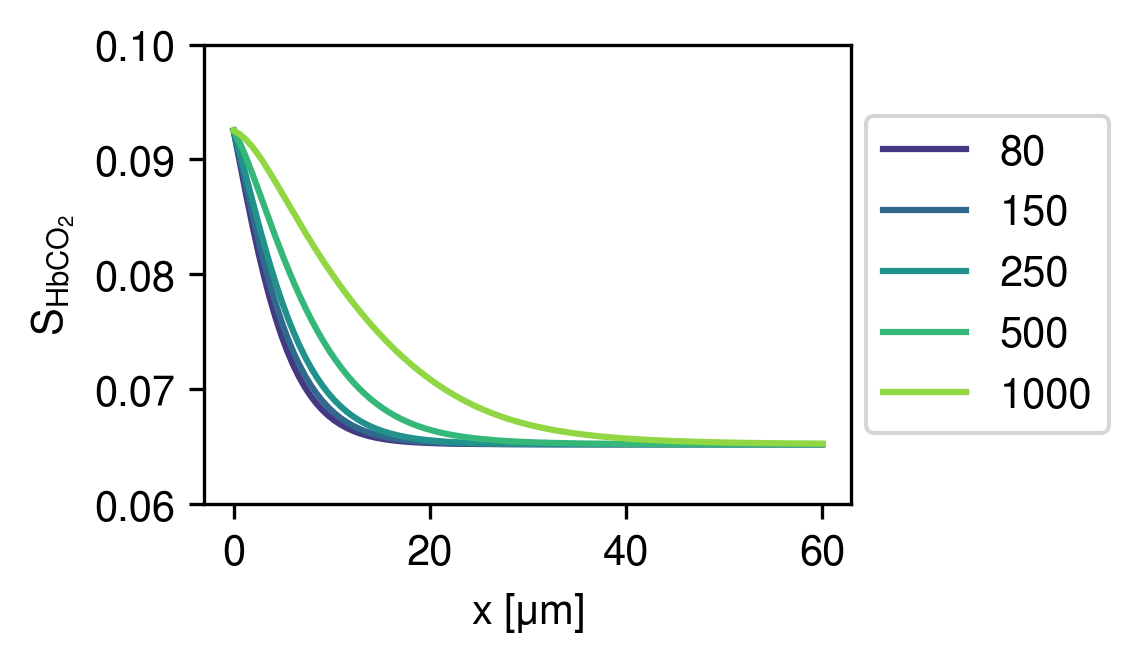

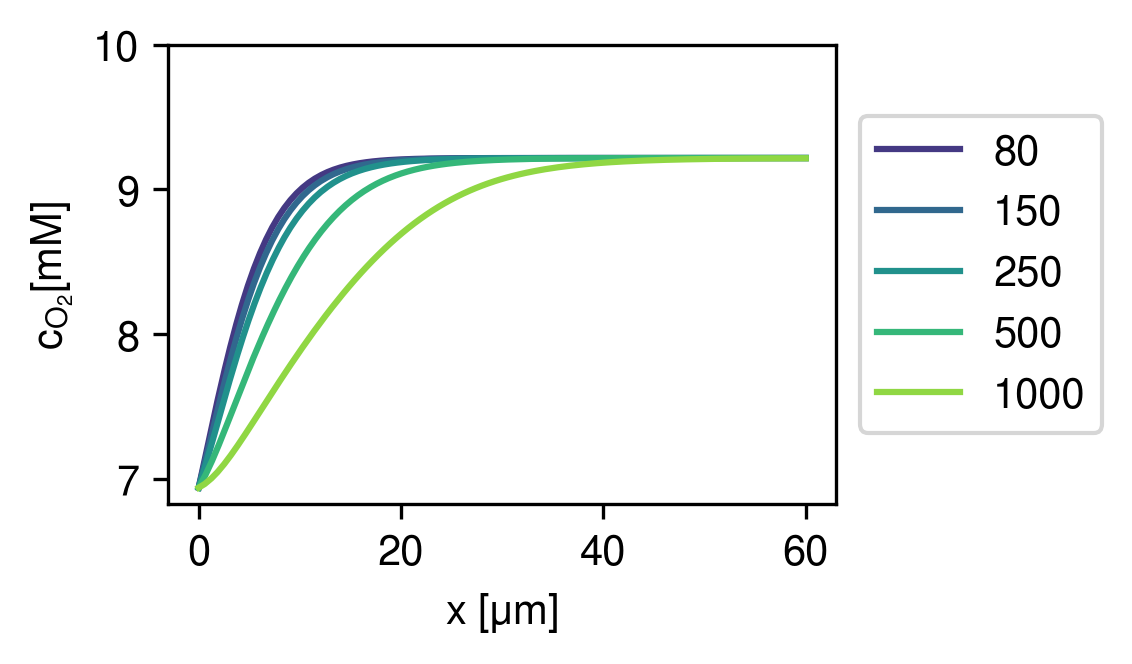

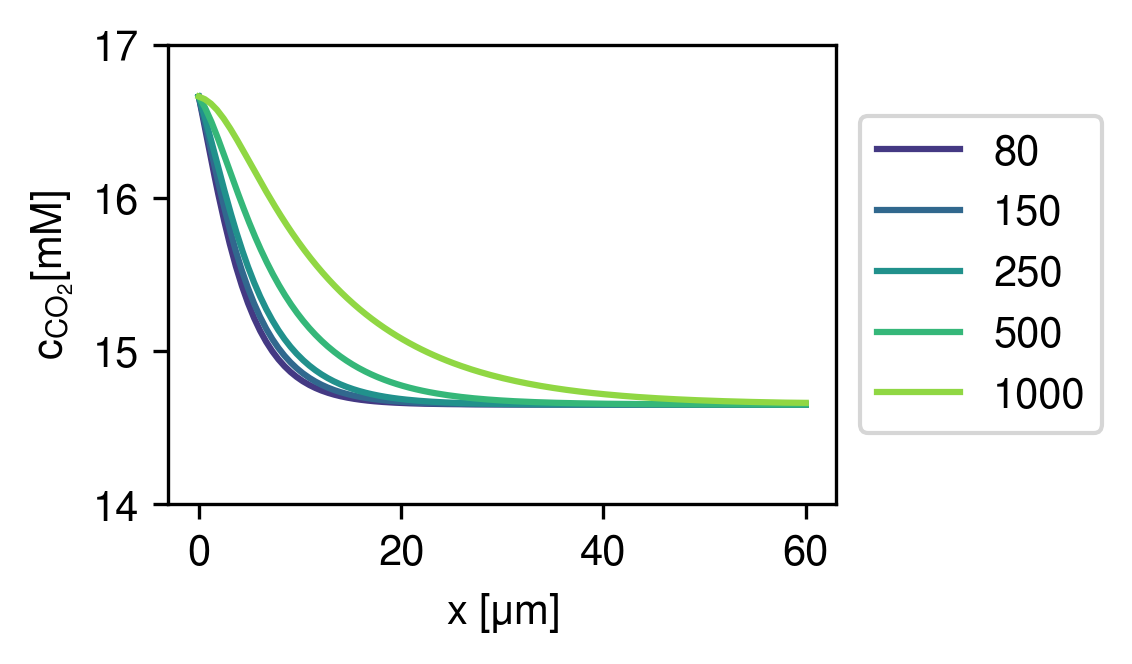

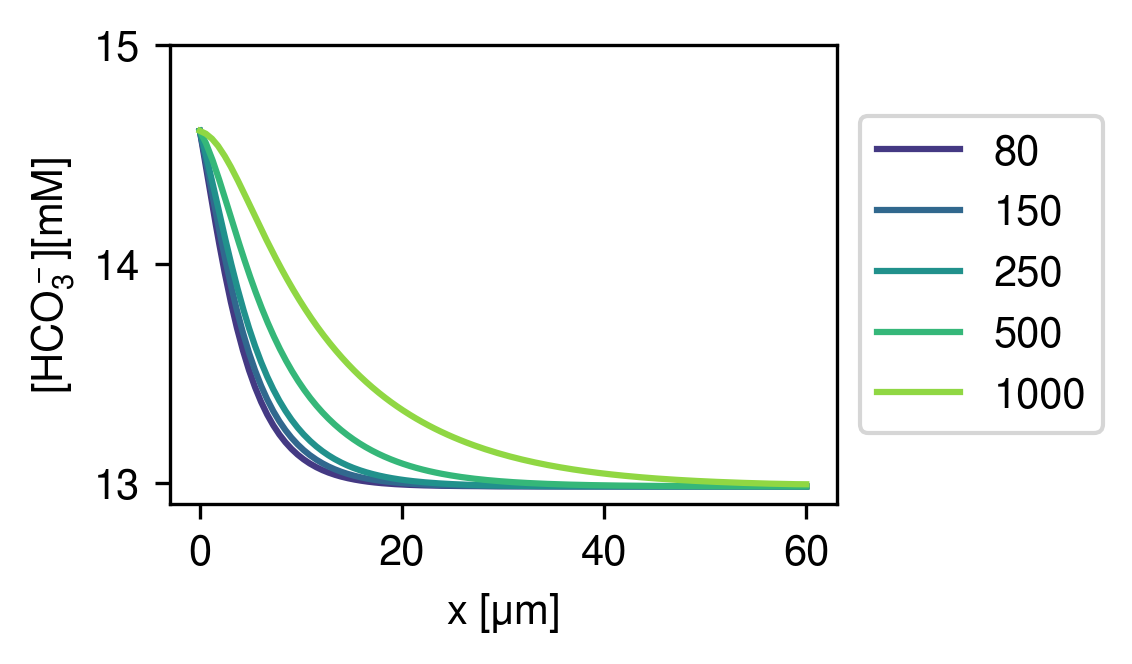

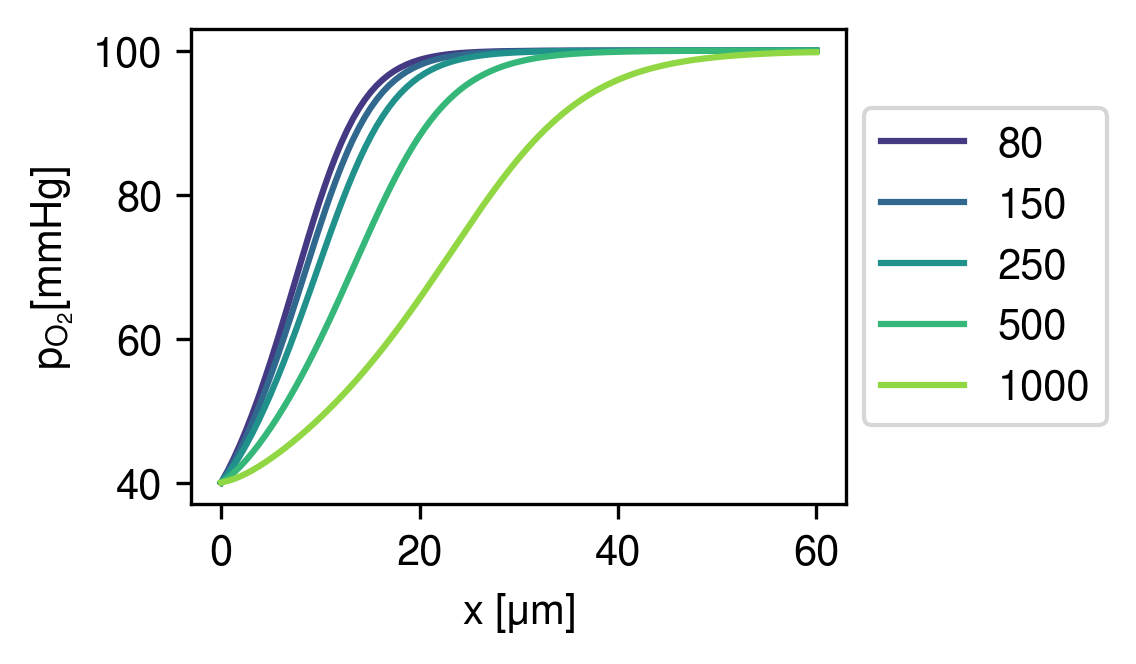

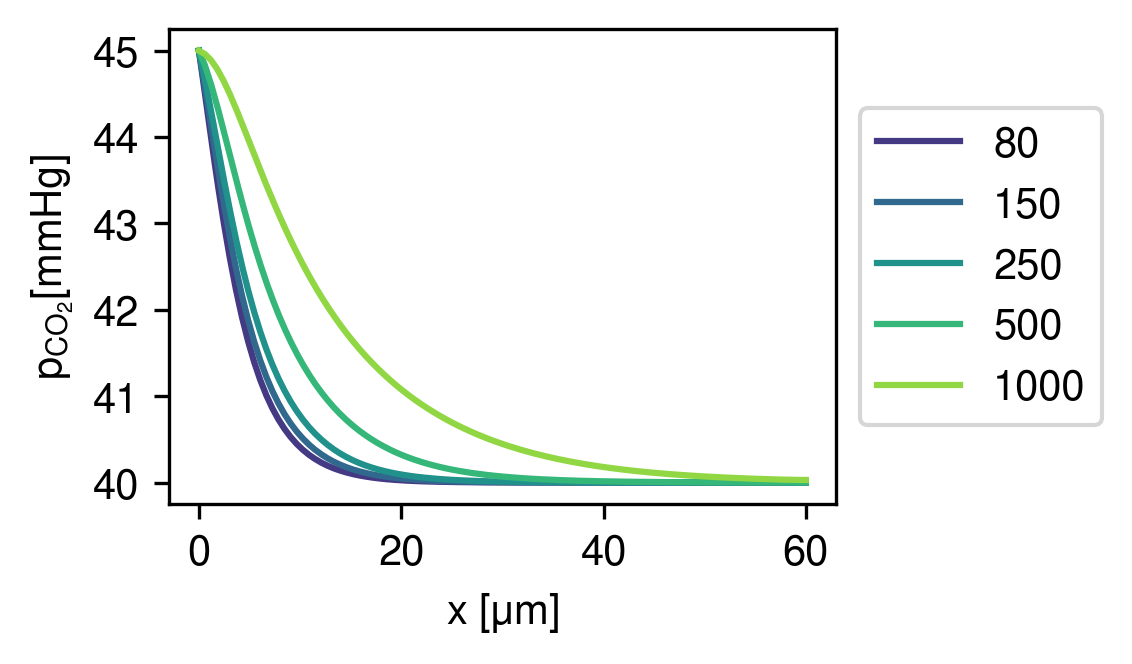

In [ ]:
# Velocity-dependent fields

colors = sns.color_palette("viridis", len(us))
ticks = [[0.7,0.8,0.9,1.0], [0.06, 0.07, 0.08, 0.09, 0.10], [7,8,9,10], [14,15,16,17], [13,14,15], [40,60,80,100], [40,41,42,43,44,45]]

j = 0
for func_name in slab_model.func_dict.keys():
    fig, ax = plt.subplots(figsize=(3.5,2.1), dpi=300, layout='constrained')
    
    i = 0
    # if j == 0:
    #     ax.plot(model.x, 0.977*np.ones_like(model.x), '--', color='black')
    for u_curr in results_us.keys():
    
        ax.plot(slab_model.x, func_factor[j]*results_us[u_curr][func_name]['4.0'], color=colors[i], label=f"{u_curr}")
        i += 1
    
    ax.set_ylabel(rf"{func_names[j]}" + rf"{func_units[j]}", size=10)
    ax.set_xlabel(r"x [$\mathdefault{\mu}$m]", size=10)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_yticks(ticks[j])
    # ax.set_ylim(min(results_us[u_curr][func_name]['4.0']), max(results_us[u_curr][func_name]['4.0']))
    ax.legend(loc='center right', bbox_to_anchor=(1.43, 0.5))
    # plt.tight_layout()
    plt.show()
    # plt.savefig(f"./figs/uvar_{func_tags[j]}.pdf", transparent=True)
    j += 1

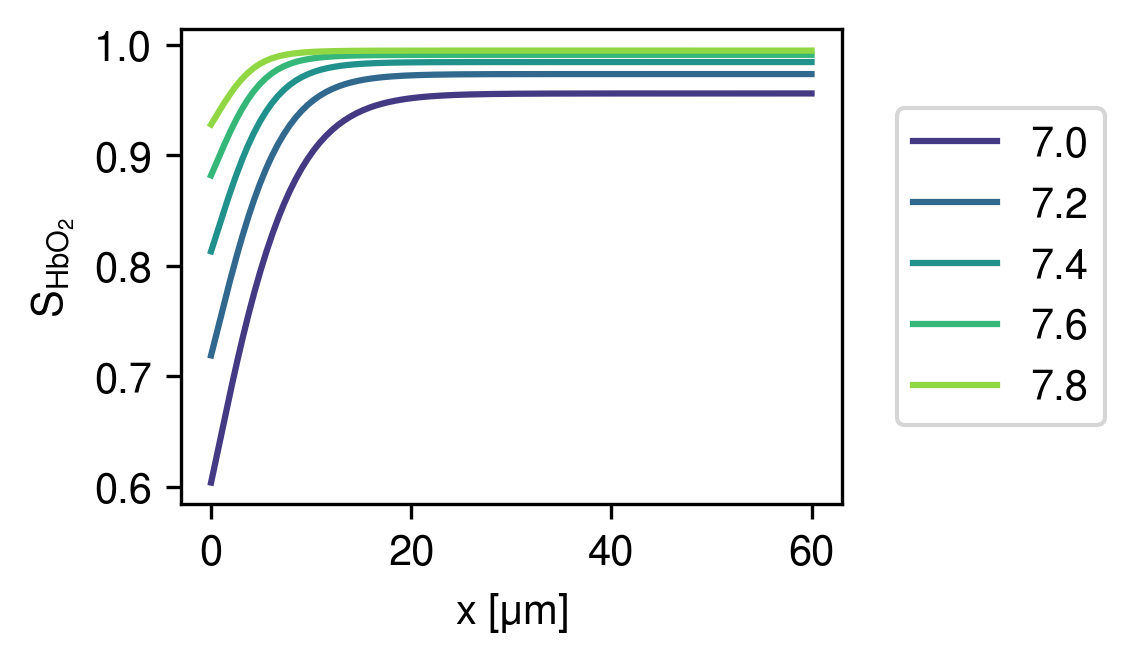

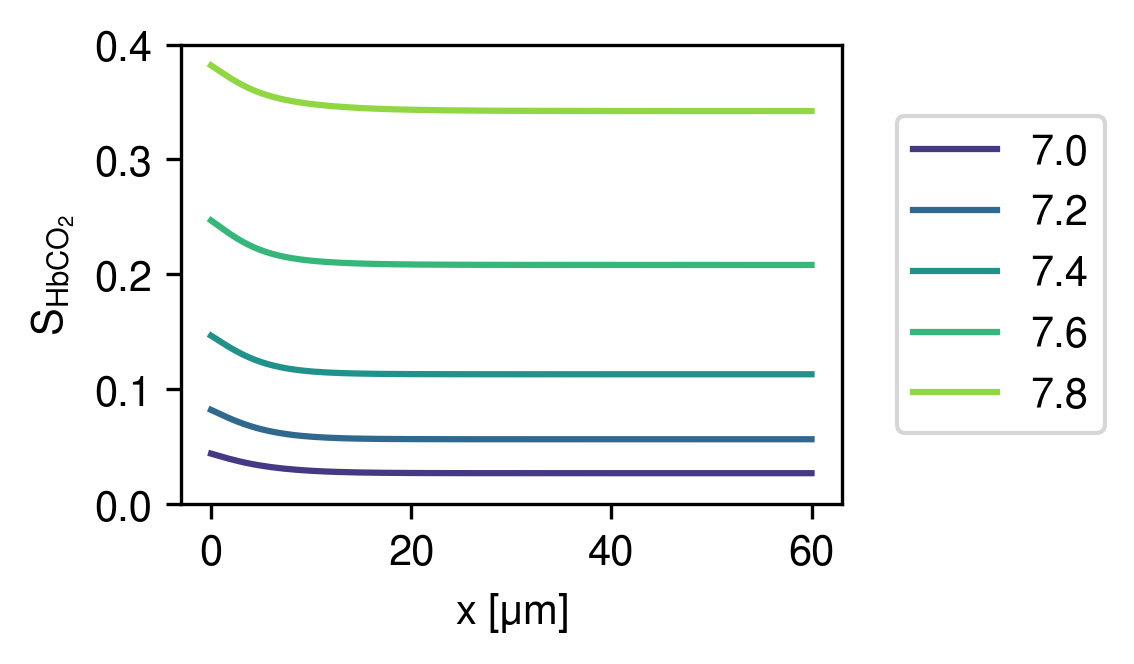

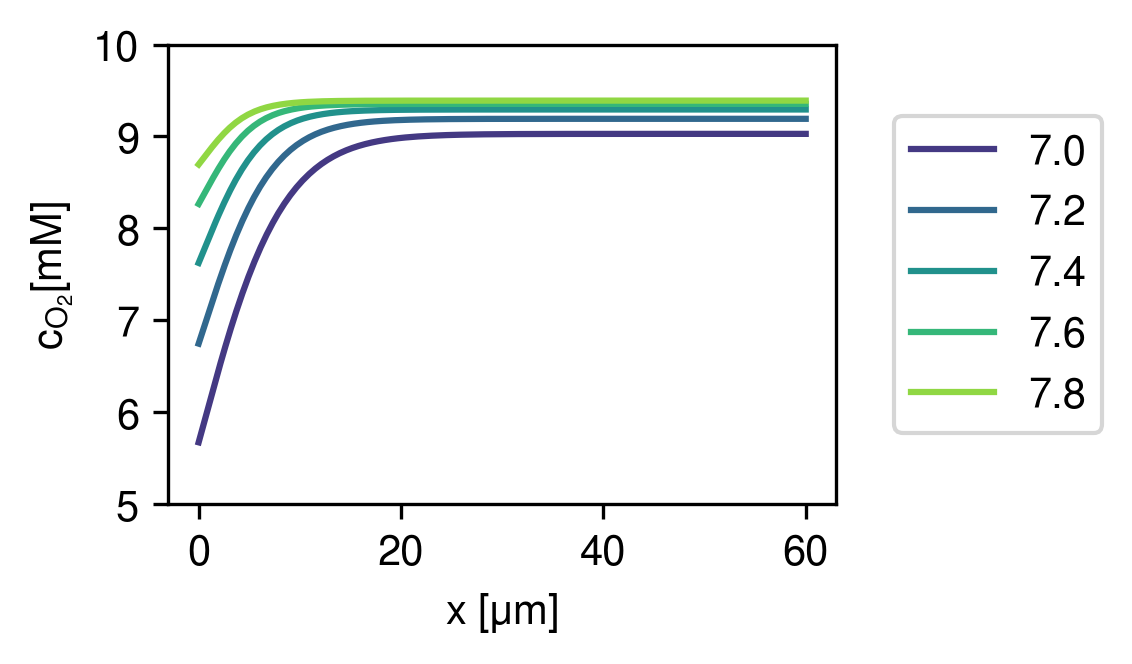

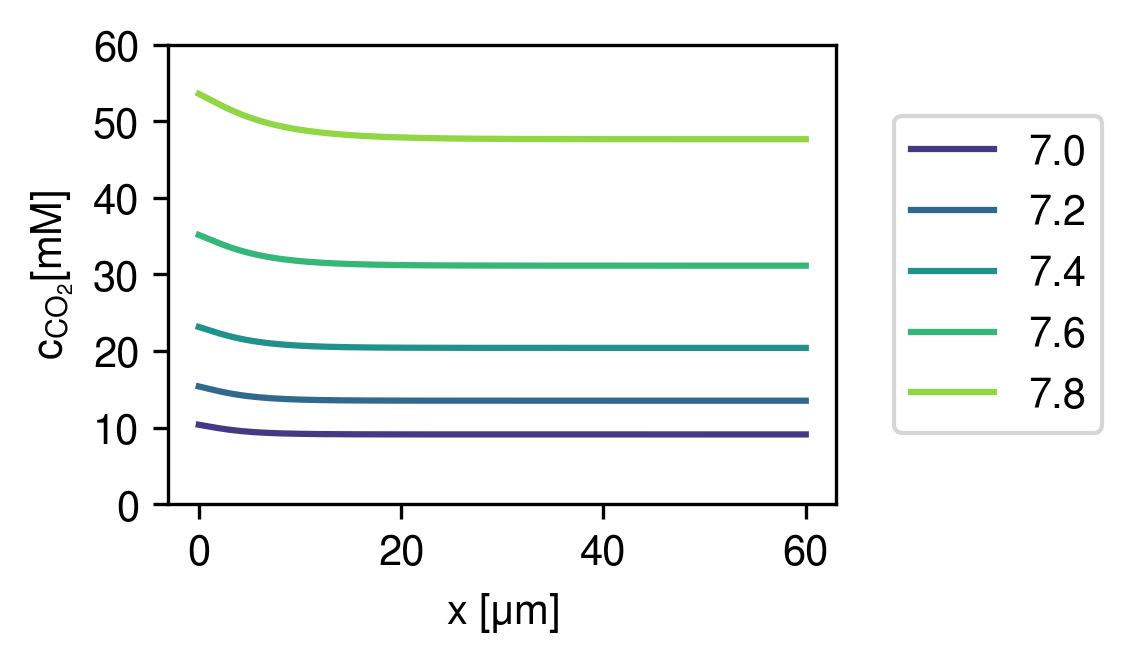

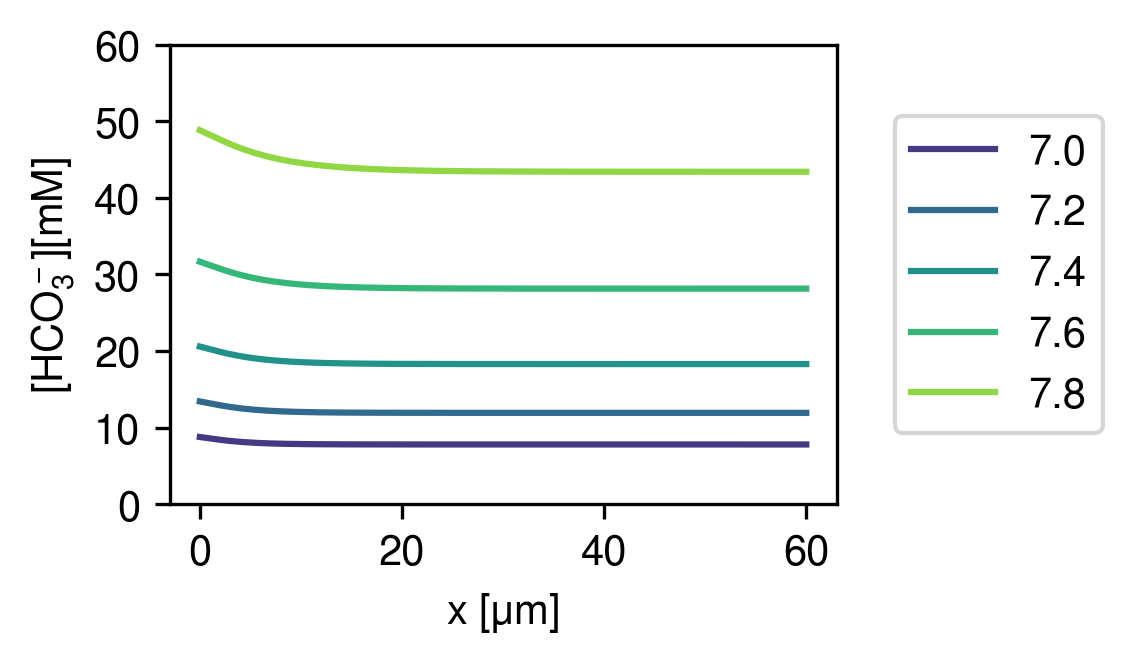

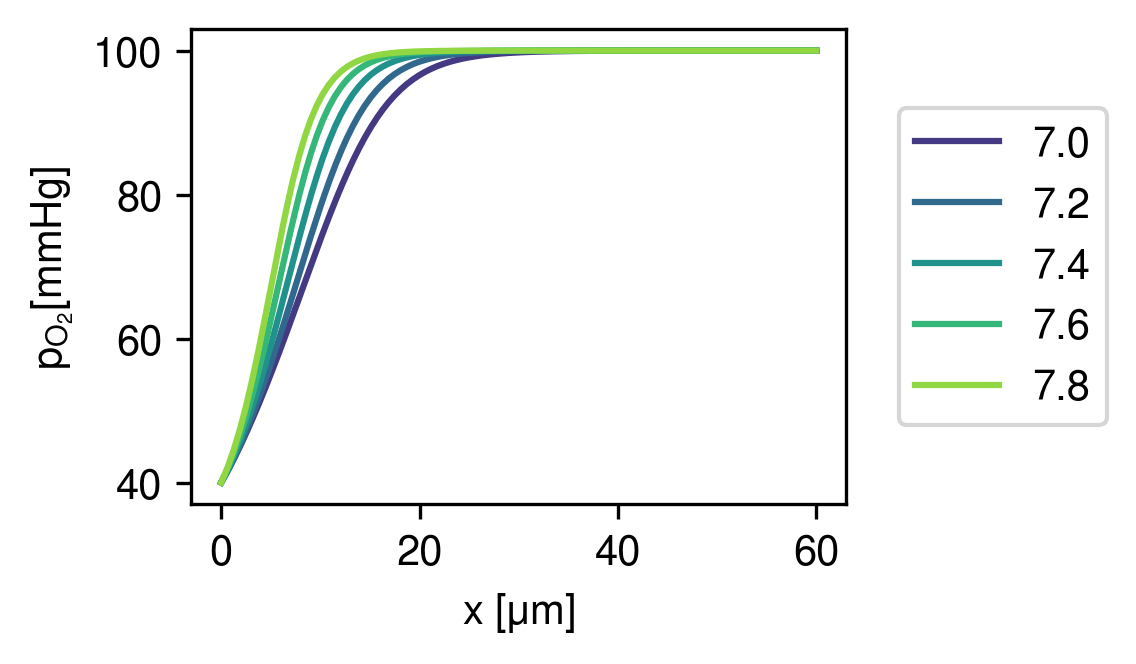

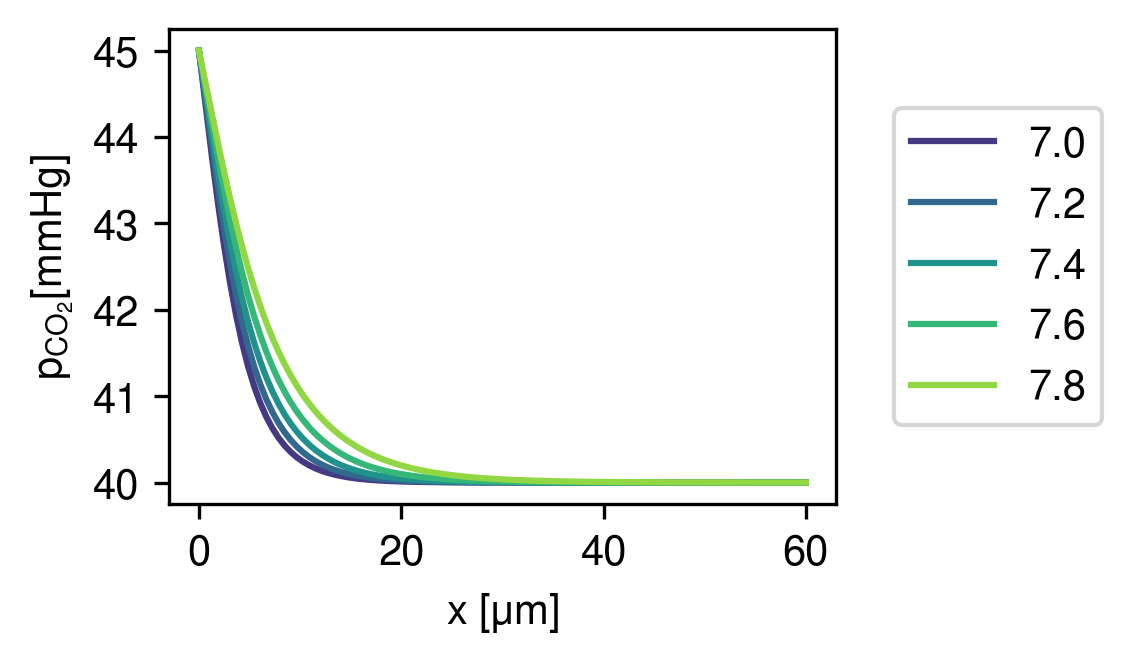

In [ ]:
# pH-dependent fields

colors = sns.color_palette("viridis", len(pHs_rbc))

ticks = [[0.6,0.7,0.8,0.9,1.0], [0.0, 0.1, 0.2, 0.3, 0.4], [5,6,7,8,9,10], [0,10,20,30,40,50,60], [0,10,20,30,40,50,60], [40,60,80,100], [40,41,42,43,44,45]]

j = 0
for func_name in slab_model.func_dict.keys():
    fig, ax = plt.subplots(figsize=(3.5,2.1), dpi=300, layout='constrained')
    i = 0
    # if j == 0:
    #     ax.plot(model.x, 0.977*np.ones_like(model.x), '--', color='black')
    for pH_curr in results_pHs.keys():
        ax.plot(slab_model.x, func_factor[j]*results_pHs[pH_curr][func_name]['4.0'], 
                color=colors[i], label=f'{pH_curr}')
        i += 1
    ax.set_ylabel(rf"{func_names[j]}" + rf"{func_units[j]}", size=10)
    ax.set_xlabel(r"x [$\mathdefault{\mu}$m]", size=10)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_yticks(ticks[j])
    # if j == 0:
        # ax.set_yticks([0.7, 0.8, 0.9, 1.0])
    # ax.set_ylim(min(results_us[u_curr][func_name]['4.0']), max(results_us[u_curr][func_name]['4.0']))
    ax.legend(loc='center right', bbox_to_anchor=(1.43, 0.5))
    # plt.tight_layout()
    plt.show()
    # plt.savefig(f"./figs/pHvar_{func_tags[j]}.pdf", transparent=True)

    j += 1

In [ ]:
exps = ["rve_225_emphysema_control", "rve_225_emphysema_1", 
        "rve_225_emphysema_2", "rve_225_emphysema_3"]

all_porosities = []
all_DL_O2 = []
all_DL_CO2 = []

for exp in exps:
    with open("./csv-results/" + exp + "_DL_O2.csv", "r") as file:
        row_num = 0
        for row in file:
            if row_num == 0:
                all_porosities.append(float(row))
            else: 
                all_DL_O2.append(float(row))
            row_num += 1
    with open("./csv-results/" + exp + "_DL_CO2.csv", "r") as file:
        row_num = 0
        for row in file:
            if row_num == 1:
                all_DL_CO2.append(float(row))
            row_num += 1

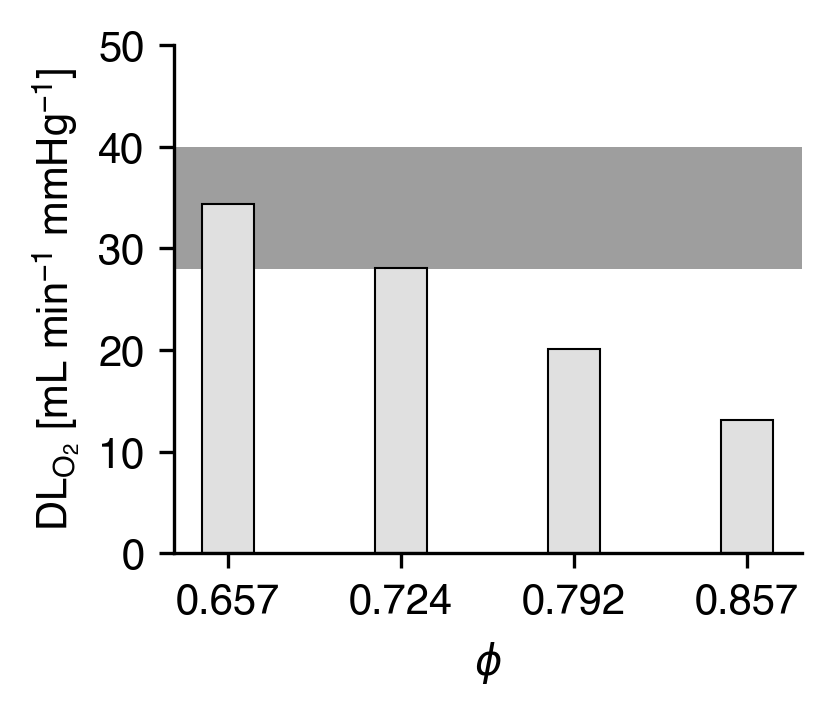

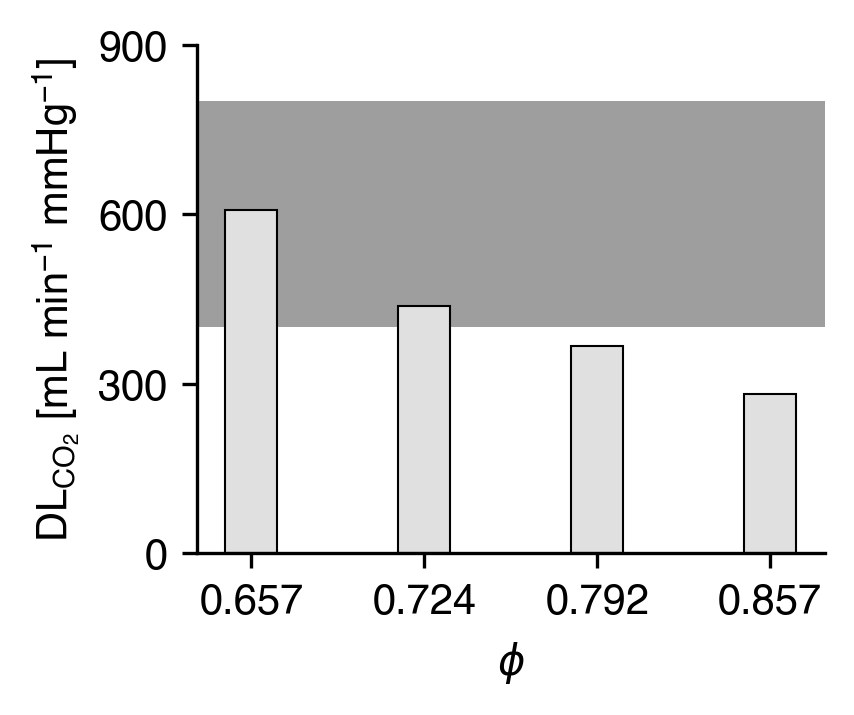

In [ ]:
# Diffusing capacity - vertical bars

fig, ax = plt.subplots(figsize=(2.7,2.2), dpi=300)

labs = np.around(all_porosities, 3)
xpos = np.arange(len(labs))
dlo2 = all_DL_O2
dlco2 = all_DL_CO2

ax.axhspan(28, 40, facecolor='#757575', alpha=0.7, zorder=1)

ax.bar(xpos, dlo2, color='#E0E0E0', width=0.3, align='center', edgecolor='black', linewidth=0.5, zorder=2)
ax.set_xticks(xpos, labels=labs)
ax.set_xlabel(r"$\phi$", size=10, rotation='horizontal', loc='center')

ax.set_ylabel(r"DL$\mathdefault{_{O_2}}$ [mL min$\mathdefault{^{-1}}$ mmHg$\mathdefault{^{-1}}$]", size=10)
ax.set_ylim(0, 50)
ax.set_yticks([0,10,20,30,40,50])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', labelsize=10)
plt.savefig("./figs/DLO2.pdf", transparent=True)
# plt.show()

fig, ax = plt.subplots(figsize=(2.7,2.2), dpi=300)

ax.axhspan(400, 800, facecolor='#757575', alpha=0.7, zorder=1)

ax.bar(xpos, dlco2, color='#E0E0E0', width=0.3, align='center', edgecolor='black', linewidth=0.5, zorder=2)
ax.set_xticks(xpos, labels=labs)
ax.set_xlabel(r"$\phi$", size=10, rotation='horizontal', loc='center')

ax.set_ylabel(r"DL$\mathdefault{_{CO_2}}$ [mL min$\mathdefault{^{-1}}$ mmHg$\mathdefault{^{-1}}$]", size=10)
ax.set_ylim(0, 900)
ax.set_yticks([0,300,600,900])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', labelsize=10)
plt.savefig("./figs/DLCO2.pdf", transparent=True)
# plt.show()

In [ ]:
mesh_path = '../raw-data/mesh225_emphysema_control/rve_225_emphysema_control.xdmf'

with io.XDMFFile(MPI.COMM_WORLD, mesh_path, 'r') as xdmf:
    rve_domain = xdmf.read_mesh(name='Grid')

In [ ]:
results_folder = r"../results-data/"
exp_folder = "rve_225_emphysema_control"

In [ ]:
model = PerfusionGasExchangeModel(mesh_path=mesh_path,
                                  results_path=results_folder,
                                  exp_path=exp_folder,
                                  params=None)

In [ ]:
model.Setup(rve_domain, atol = 1E-3, imported=True)
model.parameter_setup()

###### Geometry metrics ######
max_dims = [227.47181, 224.96266, 225.09153]
min_dims = [-2.40614, 0.04896, -0.05891]
all_volume = 3998127.625990619
tissue_volume = 11640885.717886437
air_volume = 7642758.091895818
porosity = 0.6565443796216106

Porosity = 0.657
Total boundary face number = 43532
Inlet face number = 1102
Outlet face number = 688
Air face number = 41742
